In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.5, palette='Set2')
%matplotlib inline
from collections import defaultdict
from scipy.stats import entropy
import plotly.plotly as py
import plotly.graph_objs as go
import os
from pprint import pprint
from matplotlib import cm


In [ ]:
out_path = './'

data = pd.read_csv('./processed/enrichment.csv', index_col=0) # read in our data
data.drop('24961_ZIKVDay28_20ug', axis=1, inplace=True)
metadata_cols = ['virus', 'start', 'end', 'sequence', 'strains'] # nonnumeric columns
sample_cols = [c for c in data.columns.values if c not in metadata_cols] # data columns

print data.head() # peek at the first few rows

In [ ]:
def find_all_oligos(virus, site, data=data):
    '''
    find all the integer indices 
    in the dataframe that correspond to oligos 
    containing that site
    '''
    indices = np.where((data['virus']==virus) &
                 (data['start'] <= site) & 
                 (site <= data['end']))
    return indices[0]
    
def aggregate_site(virus, site, data):
    '''Return a series of the mean value of each column for all oligos containing the input site'''
    indices = find_all_oligos(virus, site, data)
    entries = data.iloc[indices]
    agg = entries.mean(axis=0)
    return agg
        
def aggregate_virus_sites(virus, data=data, path=None):
    ''' For all sites in the viral genome in the dataset, fetch the aggregated values of all oligos containing that site'''
    if path and os.path.isfile(path):
        return pd.read_csv(path, index_col=0)

    first_site = data.loc[data['virus'] == virus]['start'].min()
    last_site = data.loc[data['virus']==virus]['end'].max()

    sites = range(first_site, last_site)
    aggregated_sites = { site: aggregate_site(virus, site, data) for site in sites }

    df = pd.DataFrame.from_dict(aggregated_sites, orient='index')
    df.to_csv(out_path + virus + '_sitewise_enrichment.csv')
    return df

site_maps = {virus: aggregate_virus_sites(virus, path='./sitewise_enrichment/%s_sitewise_enrichment.csv'%virus)
             for virus in pd.unique(data['virus'])}

In [ ]:
# def plot_interactive_binding_footprints(virus):
#     values = site_maps[virus]
#     traces = []
    
#     for serum in sample_cols:
#         if serum in ['input', 'beads']:
#             continue
            
#         vals = values[serum]
        
#         trace = go.Scatter(
#             x = vals.index.values,
#             y = vals.values,
#             mode = 'lines',
#             name = serum)
        
#         traces.append(trace)
    
#     layout = dict(title = 'Oligos from %s'%virus,
#               xaxis = dict(title = 'Genomic position'),
#               yaxis = dict(title = 'Fold enrichment by sera'),
#               )
    
#     py.iplot(traces, filename='2018-01-08_'+virus)


# for virus in flavis:
#     plot_interactive_binding_footprints(virus)

In [ ]:
# def plot_time_series(virus, serum, ax=None):
    
#     timepoints = [s for s in site_maps[virus].columns.values if serum in s and 'Day' in s]
#     timepoints.sort(key = lambda s: int(s.split('Day')[1].split('_')[0]))
#     timepoint_days = [int(s.split('Day')[1].split('_')[0]) for s in timepoints]
#     timepoint_values = {tp : site_maps[virus][tp] for tp in timepoints}
    
#     if ax == None:
#         fig, ax = plt.subplots(figsize=(12, 6))
    
#     if len(timepoints) != 2: # Currently only looking at *pairs* of timepoints
#         return
    
#     else:
#         baseline = timepoint_values[timepoints[0]]
#         comparison = timepoint_values[timepoints[1]]
        
        
#         difference = comparison.subtract(baseline)
#         label = serum.split('Day')[0] + '@ Day'+ str(timepoint_days[1]) + ' - ' + 'Day '+str(timepoint_days[0])
#         ax.plot(difference.index.values, difference.values, label=label)
#     return ax

# def plot_all_time_series(virus):
#     fig, ax = plt.subplots(figsize=(12,6))
    
#     time_series_samples = set([s.split('Day')[0] for s in sample_cols if 'Day' in s])

#     for serum in time_series_samples:
#         plot_time_series(virus, serum, ax)
#     plt.legend(title='Serum')
#     ax.set_title(virus)
#     ax.set_xlabel('Genome position')
#     ax.set_ylabel('Fold enrichment over input')
# #     ax.set_ylim(0, 150)
#     plt.show()

# flavis = ['DENV1', 'DENV2', 'DENV3', 'DENV4', 'CHIKV']
# for v in flavis:
#     plot_all_time_series(v)

In [ ]:
# def calc_entropy(row):
#     total = row[sample_cols].sum()
# #     total = row.sum()
#     if total == 0:
#         return 0.
#     distrib = row[sample_cols].map(lambda x: float(x) / float(total))
# #     distrib = row.map(lambda x: float(x) / float(total))

#     return entropy(distrib.values)

# data['entropy'] = data.apply(calc_entropy, axis=1)
# data['max_enrichment'] = data[sample_cols].max(axis=1)

In [ ]:
# def parse_time_course(df, cols):
    
#     def parse_col_header(col):
#         try:
#             sample, virusday, concentration = col.split('_')
#         except ValueError:
#             sample, virusdayconcentration = col.split('Preg')
#             sample = sample+'Preg'
#             virusday, concentration = virusdayconcentration.split('_')
            
#         virus, day = virusday.split('Day')    
#         return {'sample': sample, 'virus': virus, 'day': int(day), 'concentration': concentration}

    
#     values = df[cols]
#     new_header = { c : parse_col_header(c)['day'] for c in cols}
#     values.rename(columns=new_header, inplace=True)
#     return values

# time_courses = defaultdict(list)
# for c in sample_cols:
#     if 'Day' in c:
#         time_courses[c.split('Day')[0]].append(c)

In [ ]:
cmaps = {'ZIKV': cm.Oranges, 
          'DENV1': cm.Greens, 
          'DENV2': cm.Purples, 
          'DENV3': cm.Reds,
        'DENV4': cm.Blues}

sera_bins = { 'ZIKV': [ s for s in sample_cols if 'ZIKV' in s and 'Day0' not in s], 
             'DENV': [s for s in sample_cols if 'DENV' in s],
              'DENV1': [s for s in sample_cols if 'DENV1' in s],
              'DENV2': [s for s in sample_cols if 'DENV2' in s],
              'DENV3': [s for s in sample_cols if 'DENV3' in s],
              'DENV4': [s for s in sample_cols if 'DENV4' in s]}

sera_colors = {}

for sera, bins in sera_bins.items():
    if sera == 'DENV': 
        continue
    cm_subsection = np.linspace(0.25, 0.75,len(bins))
    if len(bins) == 1:
        colors = [cmaps[sera](.5)]
    else:
        colors = [ cmaps[sera](g) for g in cm_subsection]
    sera_colors.update({sample:color for (sample,color) in zip(bins, colors)})

In [33]:
sns.set(palette='Set2', style='whitegrid', font_scale=1.5)


def plot_binding_footprint(virus, serum, site_maps=site_maps, ax=None):
    
    values = site_maps[virus][serum]
    
    if ax == None:
        fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.plot(values.index.values, values.values, c=sera_colors[serum], label=serum.replace('20ug', '').replace('_', ' '))
    return ax

# def plot_all_binding_footprints(virus, serum_subset=sample_cols, ofile = None):
#     values = site_maps[virus]
    
#     fig, ax = plt.subplots(figsize=(9,4))    
    
#     for serum in serum_subset:
#         plot_binding_footprint(virus, serum, ax)
#     plt.legend(loc=(1.1,-0.2),title='Serum')
#     ax.set_title(virus)
#     ax.set_xlabel('Genome position')
#     ax.set_ylabel('Fold enrichment over input')
#     plt.yscale('log')
#     plt.ylim( (1, 250 ))

#     plt.tight_layout()
#     if ofile:
#         plt.savefig(out_path+ofile, dpi=300, bbox_inches='tight')
#     plt.show()
        
def plot_all_binding_footprints(virus, serum_subset=sample_cols, site_maps=site_maps, ofile = None):
    values = site_maps[virus]
    
    n_plots = len(serum_subset)
    ncols = 2
    from math import ceil
    nrows = int(ceil(float(n_plots) / float(ncols)))
    fig, axes = plt.subplots(nrows, ncols, squeeze=True, sharey=True, figsize=(12,4*nrows))    
    
    for serum, ax in zip(serum_subset, axes.flatten()):
        plot_binding_footprint(virus, serum, site_maps, ax)
        ax.set_title(serum.replace('20ug', '').replace('_', ' ')+'Serum')
        
        ax.set_xlabel('%s genome position'%virus)
        ax.set_ylabel('Fold enrichment over input')
        ax.set_ylim(ymin=1.0, ymax=65.)

#     plt.suptitle(virus, va='bottom')
#     plt.legend(loc=(1.1,-0.2),title='Serum')

#     plt.yscale('log')
#     plt.ylim( (1, 250 ))

    plt.tight_layout()
    if ofile:
        plt.savefig(out_path+ofile, dpi=300, bbox_inches='tight')
    plt.show() 

In [ ]:
plot_all_binding_footprints('ZIKV', serum_subset=sera_bins['ZIKV'], ofile='ZIKV_ZIKV.png')
plot_all_binding_footprints('ZIKV', serum_subset=sera_bins['DENV'], ofile='ZIKV_DENV.png')
# plot_all_binding_footprints('ZIKV', serum_subset=sera_bins['ZIKV']+sera_bins['DENV'], ofile='ZIKV_DENV-ZIKV.png')

for serotype in ['DENV1', 'DENV2', 'DENV3', 'DENV4']:
    plot_all_binding_footprints(serotype, serum_subset=sera_bins['DENV'], ofile='%s_DENV.png'%serotype)
    plot_all_binding_footprints(serotype, serum_subset=sera_bins['ZIKV'], ofile='%s_ZIKV.png'%serotype)
    plot_all_binding_footprints(serotype, serum_subset=sera_bins['DENV']+sera_bins['ZIKV'], ofile='%s_DENV-ZIKV.png'%serotype)

In [ ]:
data['Avg_ZIKV'] = data[sera_bins['ZIKV']].mean(axis=1)

In [ ]:
site_maps = {virus: aggregate_virus_sites(virus)
             for virus in pd.unique(data['virus'])}

In [ ]:
# plot_all_binding_footprints('ZIKV', serum_subset=sera_bins['ZIKV'], ofile='ZIKV_ZIKV.png')
plot_all_binding_footprints('ZIKV', serum_subset=sera_bins['DENV']+['Avg_ZIKV'], ofile='aggZIKV_DENV.png')
# plot_all_binding_footprints('ZIKV', serum_subset=sera_bins['ZIKV']+sera_bins['DENV'], ofile='ZIKV_DENV-ZIKV.png')

for serotype in ['DENV1', 'DENV2', 'DENV3', 'DENV4']:
#     plot_all_binding_footprints(serotype, serum_subset=sera_bins['DENV'], ofile='%s_DENV.png'%serotype)
#     plot_all_binding_footprints(serotype, serum_subset=sera_bins['ZIKV'], ofile='%s_ZIKV.png'%serotype)
    plot_all_binding_footprints(serotype, serum_subset=sera_bins['DENV']+['Avg_ZIKV'], ofile='%s_DENV-aggZIKV.png'%serotype)

In [ ]:
from glob import glob

In [ ]:
flavis=['DENV1', 'DENV2', 'DENV3', 'DENV4', 'ZIKV']
day0_maps = {v: pd.read_csv('%s_day0norm_sitewise_enrichment.csv'%v, index_col=0) for v in flavis}


In [37]:
for s in ['26021_ZIKV','26023_ZIKV', 'RM1PregZIKV']:
    
    sera_colors[s] = sera_colors['26021_ZIKVDay28_20ug']

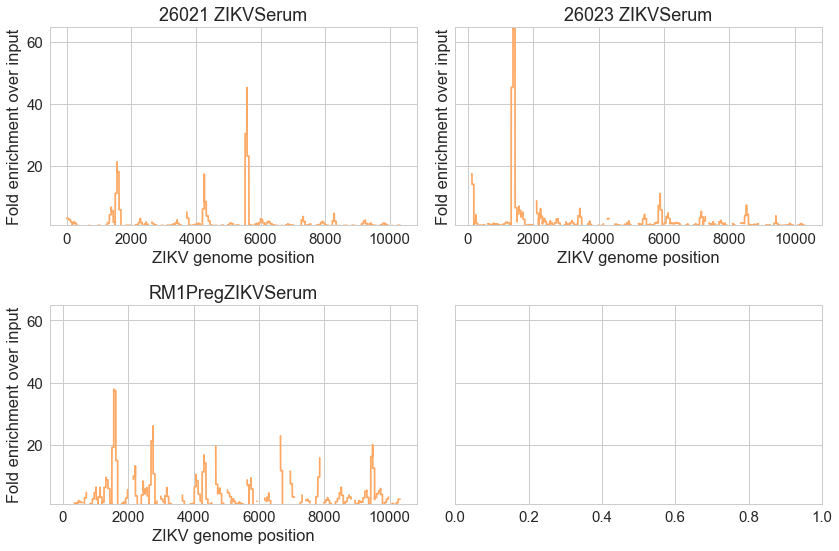

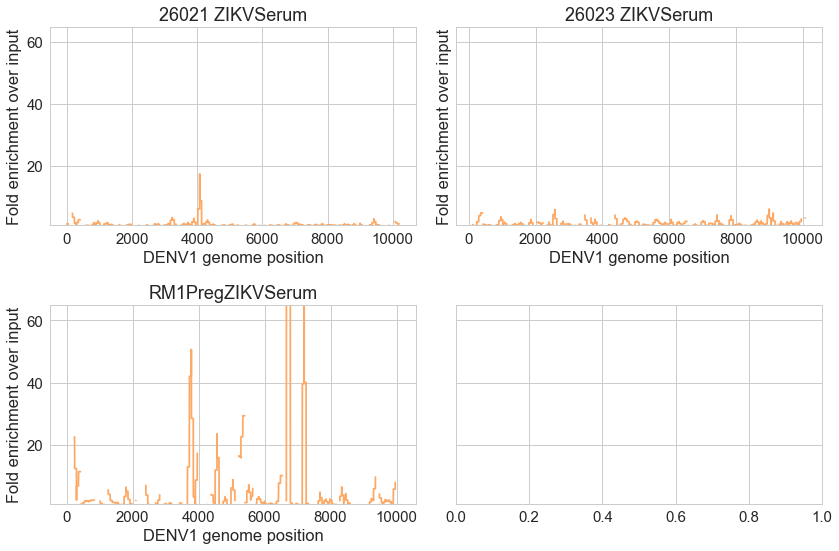

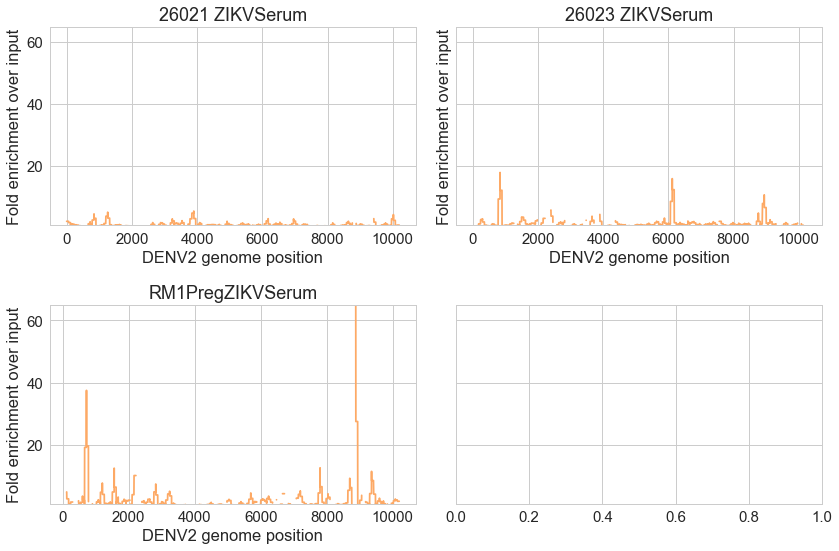

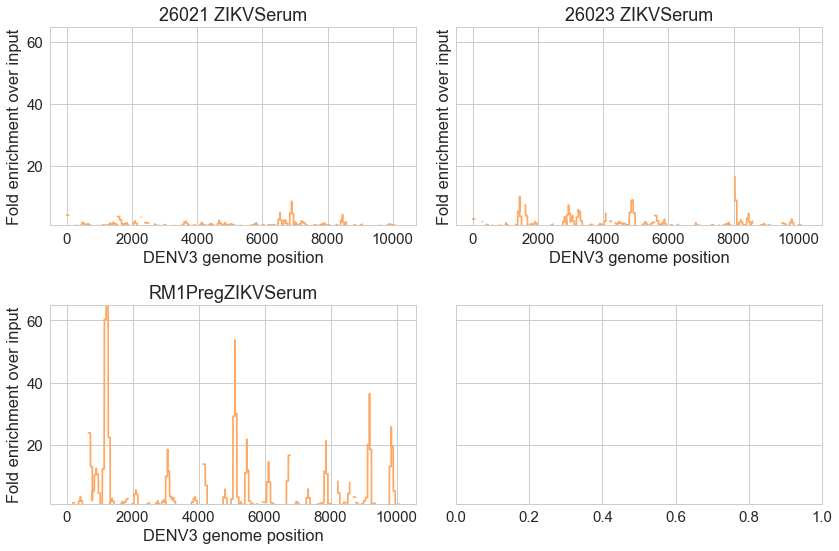

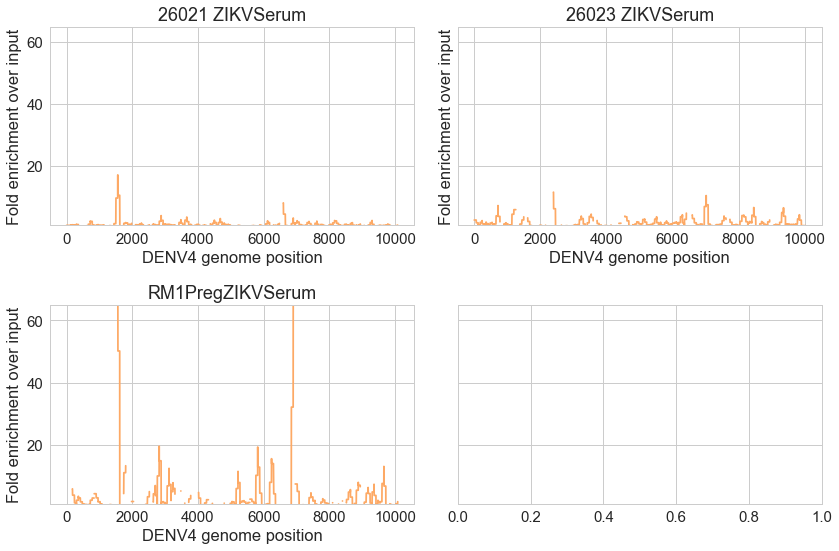

In [38]:
plot_all_binding_footprints('ZIKV', serum_subset=['26021_ZIKV','26023_ZIKV', 'RM1PregZIKV'], site_maps=day0_maps, ofile='ZIKV_Day0Normed.png')
# plot_all_binding_footprints('', serum_subset=sera_bins['DENV'], ofile='ZIKV_DENV.png')
# plot_all_binding_footprints('ZIKV', serum_subset=sera_bins['ZIKV']+sera_bins['DENV'], ofile='ZIKV_DENV-ZIKV.png')

for serotype in ['DENV1', 'DENV2', 'DENV3', 'DENV4']:
    plot_all_binding_footprints(serotype, serum_subset=['26021_ZIKV','26023_ZIKV', 'RM1PregZIKV'], site_maps=day0_maps,ofile='%s_Day0Normed.png'%serotype)

{'ZIKV':        16418_CHIKV  26021_ZIKV  26023_ZIKV  RM1PregZIKV    start      end
1         0.509397    3.302108         inf          inf      1.0    118.0
2         0.509397    3.302108         inf          inf      1.0    118.0
3         0.509397    3.302108         inf          inf      1.0    118.0
4         0.509397    3.302108         inf          inf      1.0    118.0
5         0.509397    3.302108         inf          inf      1.0    118.0
6         0.509397    3.302108         inf          inf      1.0    118.0
7         0.509397    3.302108         inf          inf      1.0    118.0
8         0.509397    3.302108         inf          inf      1.0    118.0
9         0.509397    3.302108         inf          inf      1.0    118.0
10        0.509397    3.302108         inf          inf      1.0    118.0
11        0.509397    3.302108         inf          inf      1.0    118.0
12        0.509397    3.302108         inf          inf      1.0    118.0
13        0.509397    3.30210